<a href="https://colab.research.google.com/github/yshnxd/solaris/blob/main/Copy_of_solaris_reborn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Libraries

In [1]:
# === STEP 0: Setup Libraries ===
# Core
import numpy as np
import pandas as pd
import gc
import os
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Technical indicators & TA-Lib alternative
!pip install ta --quiet
import ta

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
)

# XGBoost
!pip install xgboost --quiet
from xgboost import XGBClassifier, XGBRegressor

# Deep Learning (TensorFlow/Keras)
!pip install tensorflow --quiet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv1D, MaxPooling1D,
    LSTM, Input, BatchNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Utilities for reproducibility
import random
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries loaded successfully.")


  Preparing metadata (setup.py) ... done
✅ Libraries loaded successfully.


# Collect Data

In [2]:
# === STEP 1: Data Collection (Hourly) ===
!pip install yfinance --quiet
import yfinance as yf
from datetime import datetime
import pandas as pd
import os

# Target + market context tickers
tickers = ["AAPL", "SPY", "TSLA", "NVDA", "QQQ"]  # note: ^VIX for Yahoo
interval = "60m"  # 1-hour bars
period = "729d"   # max allowed for hourly

data_dict = {}
print("Downloading hourly data...")
for t in tickers:
    try:
        df = yf.download(t, interval=interval, period=period, progress=False)
        df.dropna(inplace=True)
        df.index = df.index.tz_localize(None)
        data_dict[t] = df
        print(f"{t}: {df.shape[0]} rows from {df.index.min()} to {df.index.max()}")
    except Exception as e:
        print(f"❌ Failed to get {t}: {e}")
# ✅ Replace old close_df creation with this
target_index = data_dict["AAPL"].index
aligned_close = pd.DataFrame(index=target_index)

for t, df in data_dict.items():
    aligned_close[t] = df.reindex(target_index)['Close']

print("\nSample aligned close prices:")
print(aligned_close.tail())

# Save raw hourly data
os.makedirs("data_raw", exist_ok=True)
for t, df in data_dict.items():
    df.to_csv(f"data_raw/{t}_60m.csv")
print("\n✅ Hourly data downloaded and saved to 'data_raw/'")


AAPL: 5075 rows from 2022-09-13 13:30:00 to 2025-08-08 19:30:00
SPY: 5075 rows from 2022-09-13 13:30:00 to 2025-08-08 19:30:00
TSLA: 5075 rows from 2022-09-13 13:30:00 to 2025-08-08 19:30:00
NVDA: 5075 rows from 2022-09-13 13:30:00 to 2025-08-08 19:30:00
QQQ: 5075 rows from 2022-09-13 13:30:00 to 2025-08-08 19:30:00

Sample aligned close prices:
                           AAPL         SPY        TSLA        NVDA  \
Datetime                                                              
2025-08-08 15:30:00  228.199997  636.875000  330.319214  182.908096   
2025-08-08 16:30:00  228.675003  636.395020  328.660004  181.884995   
2025-08-08 17:30:00  229.289993  637.219971  329.510498  182.615005   
2025-08-08 18:30:00  228.830002  637.260010  328.630005  182.695007   
2025-08-08 19:30:00  229.369995  637.119995  329.679993  182.750000   

                            QQQ  
Datetime                         
2025-08-08 15:30:00  574.000000  
2025-08-08 16:30:00  573.280029  
2025-08-08 17:30:0

#Feature Creation

Creating Features

In [3]:
all_feat_data = []

# Forward-fill aligned_close once globally
aligned_ffill = aligned_close.ffill()

for ticker in aligned_ffill.columns:
    if aligned_ffill[ticker].isna().all():
        continue

    price_series = aligned_ffill[ticker]
    feat_tmp = pd.DataFrame(index=price_series.index)

    # Lag returns
    for lag in [1, 3, 6, 12, 24]:
        feat_tmp[f"ret_{lag}h"] = price_series.pct_change(lag)

    # Rolling volatility
    for window in [6, 12, 24]:
        feat_tmp[f"vol_{window}h"] = price_series.pct_change().rolling(window).std()

    # Technical indicators
    feat_tmp["rsi_14"] = ta.momentum.RSIIndicator(price_series, window=14).rsi()
    macd = ta.trend.MACD(price_series)
    feat_tmp["macd"] = macd.macd()
    feat_tmp["macd_signal"] = macd.macd_signal()

    # Moving averages
    for w in [5, 10, 20]:
        feat_tmp[f"sma_{w}"] = price_series.rolling(w).mean()
        feat_tmp[f"ema_{w}"] = price_series.ewm(span=w, adjust=False).mean()

    # Volume features
    if ticker in data_dict and "Volume" in data_dict[ticker].columns:
        vol_series = data_dict[ticker].reindex(price_series.index)["Volume"].ffill()
        feat_tmp["vol_change_1h"] = vol_series.pct_change()
        feat_tmp["vol_ma_24h"] = vol_series.rolling(24).mean()

    # Cross-asset returns — from the globally ffilled dataframe
    for asset in ["SPY", "QQQ", "NVDA"]:
        if asset in aligned_ffill.columns:
            feat_tmp[f"{asset}_ret_1h"] = aligned_ffill[asset].pct_change()

    if "^VIX" in aligned_ffill.columns:
        feat_tmp["vix_ret_1h"] = aligned_ffill["^VIX"].pct_change()

    # Calendar features
    feat_tmp["hour"] = feat_tmp.index.hour
    feat_tmp["day_of_week"] = feat_tmp.index.dayofweek

    # Only drop rows with NaNs in features for THIS ticker
    feat_tmp = feat_tmp.dropna(subset=[col for col in feat_tmp.columns if col not in ["datetime", "ticker"]])

    feat_tmp["datetime"] = feat_tmp.index
    feat_tmp["ticker"] = ticker

    all_feat_data.append(feat_tmp.reset_index(drop=True))

features_df = pd.concat(all_feat_data, ignore_index=True)

print(f"✅ Created features for {features_df['ticker'].nunique()} tickers")
print("Shape:", features_df.shape)
print(features_df.head())


✅ Created features for 5 tickers
Shape: (25210, 26)
     ret_1h    ret_3h    ret_6h   ret_12h   ret_24h    vol_6h   vol_12h  \
0  0.007971  0.012013  0.024587  0.031305 -0.007604  0.003690  0.003882   
1  0.002602  0.008187  0.021955  0.036208 -0.003386  0.003683  0.003588   
2  0.001715  0.012327  0.018588  0.040581  0.003208  0.003681  0.003188   
3  0.011595  0.015967  0.028172  0.049035  0.016817  0.004992  0.003984   
4  0.004310  0.017698  0.026030  0.047453  0.012652  0.004917  0.003945   

    vol_24h     rsi_14      macd  ...      ema_20  vol_change_1h  \
0  0.006928  57.174728 -0.489358  ...  152.371399       0.354865   
1  0.006946  58.880818 -0.266801  ...  152.577932      -0.018507   
2  0.006880  60.014242 -0.068253  ...  152.790033       1.223954   
3  0.007246  66.708324  0.231274  ...  153.152888      -0.300933   
4  0.007102  68.822038  0.517156  ...  153.545469       0.135969   

     vol_ma_24h  SPY_ret_1h  QQQ_ret_1h  NVDA_ret_1h  hour  day_of_week  \
0  1.176824e+

Label Creation

In [4]:
# === LABEL CREATION FOR ALL TICKERS (pooled dataset) ===

horizon = 1               # predict 1 hour ahead
vol_lookback = 24         # hours to compute rolling volatility
vol_multiplier = 0.5      # threshold scaling vs volatility

all_data = []

for ticker in aligned_close.columns:
    # Skip if ticker is all NaN (e.g., ^VIX alignment issues)
    if aligned_close[ticker].dropna().empty:
        continue

    price_series = aligned_close[ticker]

    # Forward return
    future_price = price_series.shift(-horizon)
    future_ret = (future_price - price_series) / price_series

    # Volatility-based threshold
    rolling_vol = price_series.pct_change().rolling(vol_lookback).std()
    threshold = rolling_vol * vol_multiplier

    # Label creation
    label = future_ret.copy()
    label[future_ret > threshold] = 1    # Up
    label[future_ret < -threshold] = -1  # Down
    label[(future_ret <= threshold) & (future_ret >= -threshold)] = 0  # Neutral

    # Drop NaNs
    label = label.dropna()

    # Combine into dataframe
    df_tmp = pd.DataFrame({
        "datetime": label.index,
        "ticker": ticker,
        "price": price_series.loc[label.index],
        "label": label.values,
        "future_ret": future_ret.loc[label.index],
        "volatility": rolling_vol.loc[label.index]
    })

    all_data.append(df_tmp)

# Combine all tickers
labels_df = pd.concat(all_data, ignore_index=True)

print("Combined dataset shape:", labels_df.shape)
print(labels_df["label"].value_counts(normalize=True))
labels_df.head(10)


Combined dataset shape: (25370, 6)
label
 0.000000    0.532322
 1.000000    0.245171
-1.000000    0.217777
-0.009297    0.000039
-0.006482    0.000039
               ...   
 0.004660    0.000039
-0.013126    0.000039
-0.002298    0.000039
-0.002268    0.000039
 0.002448    0.000039
Name: proportion, Length: 123, dtype: float64


,datetime,ticker,price,label,future_ret,volatility
0,2022-09-13 13:30:00,AAPL,157.820007,-0.008618,-0.008618,NaN
1,2022-09-13 14:30:00,AAPL,156.459900,-0.001324,-0.001324,NaN
2,2022-09-13 15:30:00,AAPL,156.252701,0.001647,0.001647,NaN
3,2022-09-13 16:30:00,AAPL,156.509995,-0.009297,-0.009297,NaN
4,2022-09-13 17:30:00,AAPL,155.054993,-0.006482,-0.006482,NaN
5,2022-09-13 18:30:00,AAPL,154.050003,-0.001298,-0.001298,NaN
6,2022-09-13 19:30:00,AAPL,153.850006,0.007410,0.007410,NaN
7,2022-09-14 13:30:00,AAPL,154.990005,0.006065,0.006065,NaN
8,2022-09-14 14:30:00,AAPL,155.929993,-0.003912,-0.003912,NaN
9,2022-09-14 15:30:00,AAPL,155.320007,-0.001642,-0.001642,NaN


Scaling

# Preprocessing

Normalize Features

In [5]:
# Merge features with labels
df = features_df.merge(labels_df, on=["datetime", "ticker"], how="inner")

# Drop NaNs (just in case)
df = df.dropna()

# Separate features & labels
X = df.drop(columns=["datetime", "ticker", "label", "future_ret"])
y = df["label"]

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True))


X shape: (25205, 26)
y distribution:
 label
 0.0    0.534854
 1.0    0.245983
-1.0    0.219163
Name: proportion, dtype: float64


Scale

In [6]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Merge features and labels
df = features_df.merge(labels_df, on=["datetime", "ticker"], how="inner")

# Sort by time
df = df.sort_values(["datetime", "ticker"]).reset_index(drop=True)

# Replace inf values with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaNs
df = df.dropna()

# Separate features & target
X = df.drop(columns=["datetime", "ticker", "label", "future_ret"])
y = df["label"]

# Time-based split
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]

X_test = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]

# Ensure all values are finite before scaling
assert np.isfinite(X_train.values).all(), "Found non-finite values in X_train!"

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"✅ Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("Label distribution in Train:", y_train.value_counts(normalize=True))


✅ Train: (17631, 26), Val: (3778, 26), Test: (3779, 26)
Label distribution in Train: label
 0.0    0.525325
 1.0    0.252056
-1.0    0.222619
Name: proportion, dtype: float64


Sequence making - For LSTM AND CNN

In [7]:
import numpy as np

def create_sequences(X, y, seq_len=24):
    """
    Convert tabular (samples, features) into sequential (samples, seq_len, features)
    for CNN/LSTM, keeping labels aligned to the last timestep.
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])  # label at next hour
    return np.array(X_seq), np.array(y_seq)

# === Choose sequence length ===
SEQ_LEN = 24  # last 24 hours to predict next hour

# Reshape train/val/test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, SEQ_LEN)
X_val_seq,   y_val_seq   = create_sequences(X_val,   y_val.values,   SEQ_LEN)
X_test_seq,  y_test_seq  = create_sequences(X_test,  y_test.values,  SEQ_LEN)

print(f"Train seq: {X_train_seq.shape}, Val seq: {X_val_seq.shape}, Test seq: {X_test_seq.shape}")


Train seq: (17607, 24, 26), Val seq: (3754, 24, 26), Test seq: (3755, 24, 26)


In [8]:
# CELL 1 — label encoding + class weights
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

# mapping: -1 -> 0 (down), 0 -> 1 (neutral), 1 -> 2 (up)
label_map = { -1.0: 0, 0.0: 1, 1.0: 2 }

# If your y_* are numpy arrays (seq labels), convert
y_train_seq_mapped = np.vectorize(label_map.get)(y_train_seq)
y_val_seq_mapped   = np.vectorize(label_map.get)(y_val_seq)
y_test_seq_mapped  = np.vectorize(label_map.get)(y_test_seq)

# one-hot for Keras
y_train_cat = to_categorical(y_train_seq_mapped, num_classes=3)
y_val_cat   = to_categorical(y_val_seq_mapped, num_classes=3)
y_test_cat  = to_categorical(y_test_seq_mapped, num_classes=3)

# compute class weights from training sequence labels
classes = np.unique(y_train_seq_mapped)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train_seq_mapped)
class_weights_dict = {int(c): w for c, w in zip(classes, class_weights)}
print("Class weights:", class_weights_dict)
print("Train class distribution:", np.bincount(y_train_seq_mapped) / len(y_train_seq_mapped))


Class weights: {0: np.float64(1.4983405667602758), 1: np.float64(0.6344179007674846), 2: np.float64(1.322144627168281)}
Train class distribution: [0.22246834 0.52541603 0.25211564]


# Build the Model

CNN

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, Dropout,
    GlobalAveragePooling1D, Dense, Add
)
from tensorflow.keras.optimizers import Adam

def residual_block(x, filters, kernel_size, dropout_rate=0.2):
    # Shortcut projection if needed
    shortcut = x
    if x.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv1D(filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv1D(filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_cnn_enhanced(input_shape, n_classes=3, dropout_rate=0.3):
    inp = Input(shape=input_shape)

    # Initial convolution
    x = Conv1D(64, kernel_size=3, padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks with increasing filters
    x = residual_block(x, 64, 3, dropout_rate=dropout_rate)
    x = residual_block(x, 128, 5, dropout_rate=dropout_rate)
    x = residual_block(x, 256, 3, dropout_rate=dropout_rate)

    # Global pooling + Dense layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build the model
cnn_model = build_cnn_enhanced(input_shape=X_train_seq.shape[1:], n_classes=3, dropout_rate=0.3)
cnn_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24, 26)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 24, 64)    │      5,056 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 24, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 24, 64)    │     12,352 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 24, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 64)    │          0 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 24, 64)    │     12,352 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 24, 64)    │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 24, 128)   │     41,088 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 128)   │        512 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 24, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24, 128)   │          0 │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 24, 128)   │     82,048 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 24, 128)   │      8,320 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 128)   │        512 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 594,115 (2.27 MB)

 Trainable params: 591,427 (2.26 MB)

 Non-trainable params: 2,688 (10.50 KB)

LSTM

In [11]:
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, GRU, Dense, Dropout,
    LayerNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D,
    Concatenate, Attention
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_lstm_enhanced(input_shape, n_classes=3, dropout_rate=0.25):
    inp = Input(shape=input_shape)
    x = LayerNormalization()(inp)

    # First BiLSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)

    # Second BiGRU layer (faster and adds diversity in sequence modeling)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = Dropout(0.2)(x)

    # Self-Attention layer
    attn_data = Attention()([x, x])
    x = Concatenate()([x, attn_data])  # fuse original and attention output

    # Pooling
    x_avg = GlobalAveragePooling1D()(x)
    x_max = GlobalMaxPooling1D()(x)
    x = Concatenate()([x_avg, x_max])

    # Dense layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate model
lstm_model = build_lstm_enhanced(input_shape=X_train_seq.shape[1:], n_classes=3, dropout_rate=0.25)
lstm_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 24, 26)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 26)    │         52 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 256)   │    158,720 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 24, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 24, 128)   │    123,648 │ dropout_7[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 24, 128)   │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 128)   │          0 │ dropout_8[0][0],  │
│ (Attention)         │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24, 256)   │          0 │ dropout_8[0][0],  │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ concatenate[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ concatenate[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128)       │          0 │ dense_4[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │        387 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 447,031 (1.71 MB)

 Trainable params: 447,031 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

XGBOOST

In [13]:
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np

# Map labels to 0,1,2
label_map = { -1.0: 0, 0.0: 1, 1.0: 2 }
y_train_tab = np.vectorize(label_map.get)(y_train)
y_val_tab   = np.vectorize(label_map.get)(y_val)
y_test_tab  = np.vectorize(label_map.get)(y_test)

# Class-balanced sample weights
sample_weight = compute_sample_weight('balanced', y_train_tab)

# Class imbalance handling (per-class scaling)
class_counts = np.bincount(y_train_tab)
total = len(y_train_tab)
scale_weights = [total / (len(class_counts) * c) for c in class_counts]

xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=600,               # more trees for better learning
    learning_rate=0.03,             # lower LR for more stable learning
    max_depth=6,                    # slightly deeper trees
    max_leaves=32,                   # controls tree complexity
    min_child_weight=3,              # avoids too-specific splits
    gamma=1,                         # min loss reduction to split
    subsample=0.85,                  # random row sampling
    colsample_bytree=0.85,           # random feature sampling
    reg_alpha=0.1,                   # L1 regularization
    reg_lambda=1.0,                  # L2 regularization
    random_state=42,
    n_jobs=-1,
    tree_method='hist',              # fast CPU method; use 'gpu_hist' if GPU is available
    scale_pos_weight=scale_weights[1], # handles imbalance for the positive class (for binary) — here we might ignore for multi
    eval_metric='mlogloss'
)



# Train the model

CNN

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow as tf
import datetime

# Enable mixed precision if supported
if tf.config.list_physical_devices('GPU'):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Compile with lower LR initially for stability
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

chk = ModelCheckpoint(
    filepath='best_cnn_full_model.keras',  # save full model, not just weights
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# TensorBoard logging
log_dir = "logs/cnn/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training
cnn_history = cnn_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=100,
    batch_size=128,
    class_weight=class_weights_dict,
    callbacks=[es, rlr, chk, tb_callback],
    verbose=2
)


Epoch 1/100

Epoch 1: val_loss improved from inf to 1.07967, saving model to best_cnn_full_model.keras
138/138 - 53s - 386ms/step - accuracy: 0.3705 - loss: 1.1104 - val_accuracy: 0.4326 - val_loss: 1.0797 - learning_rate: 5.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 1.07967 to 1.07437, saving model to best_cnn_full_model.keras
138/138 - 83s - 604ms/step - accuracy: 0.4221 - loss: 1.0875 - val_accuracy: 0.4547 - val_loss: 1.0744 - learning_rate: 5.0000e-04
Epoch 3/100

Epoch 3: val_loss improved from 1.07437 to 1.03092, saving model to best_cnn_full_model.keras
138/138 - 79s - 575ms/step - accuracy: 0.4347 - loss: 1.0797 - val_accuracy: 0.5112 - val_loss: 1.0309 - learning_rate: 5.0000e-04
Epoch 4/100

Epoch 4: val_loss did not improve from 1.03092
138/138 - 82s - 591ms/step - accuracy: 0.4519 - loss: 1.0712 - val_accuracy: 0.4435 - val_loss: 1.0725 - learning_rate: 5.0000e-04
Epoch 5/100

Epoch 5: val_loss did not improve from 1.03092
138/138 - 45s - 324ms/step - accuracy: 

LSTM

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow as tf
import datetime

# Enable mixed precision if GPU supports it (LSTMs benefit less than CNNs, but still good for speed)
if tf.config.list_physical_devices('GPU'):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Compile LSTM with gradient clipping (helps with exploding gradients in RNNs)
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

chk = ModelCheckpoint(
    filepath='best_lstm_full_model.keras',  # Save entire model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# TensorBoard logging
log_dir = "logs/lstm/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training
lstm_history = lstm_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=120,  # Give it more room to converge
    batch_size=96,  # Smaller batch size often helps LSTM generalization
    class_weight=class_weights_dict,
    callbacks=[es, rlr, chk, tb_callback],
    verbose=2
)


Epoch 1/120

Epoch 1: val_loss improved from inf to 1.11030, saving model to best_lstm_full_model.keras
184/184 - 55s - 300ms/step - accuracy: 0.4015 - loss: 1.0903 - val_accuracy: 0.3487 - val_loss: 1.1103 - learning_rate: 3.0000e-04
Epoch 2/120

Epoch 2: val_loss improved from 1.11030 to 1.07659, saving model to best_lstm_full_model.keras
184/184 - 82s - 446ms/step - accuracy: 0.4341 - loss: 1.0765 - val_accuracy: 0.4204 - val_loss: 1.0766 - learning_rate: 3.0000e-04
Epoch 3/120

Epoch 3: val_loss did not improve from 1.07659
184/184 - 81s - 443ms/step - accuracy: 0.4465 - loss: 1.0689 - val_accuracy: 0.3924 - val_loss: 1.0987 - learning_rate: 3.0000e-04
Epoch 4/120

Epoch 4: val_loss did not improve from 1.07659
184/184 - 44s - 240ms/step - accuracy: 0.4574 - loss: 1.0606 - val_accuracy: 0.3974 - val_loss: 1.0953 - learning_rate: 3.0000e-04
Epoch 5/120

Epoch 5: val_loss did not improve from 1.07659
184/184 - 83s - 453ms/step - accuracy: 0.4688 - loss: 1.0511 - val_accuracy: 0.4068 

XGBOOST

In [17]:
!pip install optuna --quiet

import optuna
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# ============================
# Optuna objective function
# ============================
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'tree_method': 'hist',  # Change to 'gpu_hist' if GPU available
        'seed': 42,

        # Hyperparameters to tune
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 3.0),
    }

    # DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train_tab)
    dval = xgb.DMatrix(X_val, label=y_val_tab)

    # Train with early stopping
    evals = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=30,
        verbose_eval=False
    )

    # Validation predictions
    preds = model.predict(dval)
    pred_labels = np.argmax(preds, axis=1)

    return accuracy_score(y_val_tab, pred_labels)

# ============================
# Run Optuna study
# ============================
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Try 50 parameter sets

print("\nBest parameters:", study.best_params)
print("Best validation accuracy:", study.best_value)

# ============================
# Train final model with best params
# ============================
best_params = study.best_params
best_params.update({
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',  # Or 'gpu_hist'
    'seed': 42
})

dtrain = xgb.DMatrix(X_train, label=y_train_tab)
dval = xgb.DMatrix(X_val, label=y_val_tab)
dtest = xgb.DMatrix(X_test)

evals = [(dtrain, 'train'), (dval, 'eval')]
final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=1500,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=50
)

# ============================
# Evaluate on test set
# ============================
y_prob = final_model.predict(dtest)
y_pred = np.argmax(y_prob, axis=1)
test_acc = accuracy_score(y_test_tab, y_pred)
print("\nFinal Test Accuracy:", test_acc)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 9.9 MB/s eta 0:00:00


[I 2025-08-11 13:11:27,016] A new study created in memory with name: no-name-4b49761b-af0d-40c2-adaf-454621602ad6
[I 2025-08-11 13:11:32,192] Trial 0 finished with value: 0.5688194812069878 and parameters: {'max_depth': 3, 'learning_rate': 0.02231350205413467, 'subsample': 0.6169255393733186, 'colsample_bytree': 0.805613833521202, 'gamma': 2.8654092777286637, 'min_child_weight': 6, 'reg_alpha': 0.5094164809696309, 'reg_lambda': 1.9173460639593571}. Best is trial 0 with value: 0.5688194812069878.
[I 2025-08-11 13:11:50,086] Trial 1 finished with value: 0.5561143462149285 and parameters: {'max_depth': 9, 'learning_rate': 0.026507103249523163, 'subsample': 0.646664551451375, 'colsample_bytree': 0.9503787705439664, 'gamma': 0.8003582316298191, 'min_child_weight': 1, 'reg_alpha': 0.3066024031896877, 'reg_lambda': 2.8326926150143015}. Best is trial 0 with value: 0.5688194812069878.
[I 2025-08-11 13:11:51,549] Trial 2 finished with value: 0.5516146109052409 and parameters: {'max_depth': 8, 'l


Best parameters: {'max_depth': 3, 'learning_rate': 0.02845916357450999, 'subsample': 0.7552507762672391, 'colsample_bytree': 0.6666641910069, 'gamma': 4.394916003559231, 'min_child_weight': 5, 'reg_alpha': 0.5856294446650139, 'reg_lambda': 1.838450350300456}
Best validation accuracy: 0.5696135521439916
[0]	train-mlogloss:1.09381	eval-mlogloss:1.09371
[50]	train-mlogloss:0.99107	eval-mlogloss:0.98831
[100]	train-mlogloss:0.97124	eval-mlogloss:0.96997
[150]	train-mlogloss:0.96354	eval-mlogloss:0.96515
[200]	train-mlogloss:0.95937	eval-mlogloss:0.96353
[250]	train-mlogloss:0.95628	eval-mlogloss:0.96241
[300]	train-mlogloss:0.95466	eval-mlogloss:0.96200
[350]	train-mlogloss:0.95309	eval-mlogloss:0.96196
[361]	train-mlogloss:0.95293	eval-mlogloss:0.96197

Final Test Accuracy: 0.5800476316485843


118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
📊 CNN Accuracy: 37.5233%

Classification Report:
              precision    recall  f1-score   support

           0     0.2025    0.2801    0.2350       757
           1     0.5532    0.4623    0.5037      2124
           2     0.2304    0.2460    0.2380       874

    accuracy                         0.3752      3755
   macro avg     0.3287    0.3295    0.3256      3755
weighted avg     0.4074    0.3752    0.3877      3755



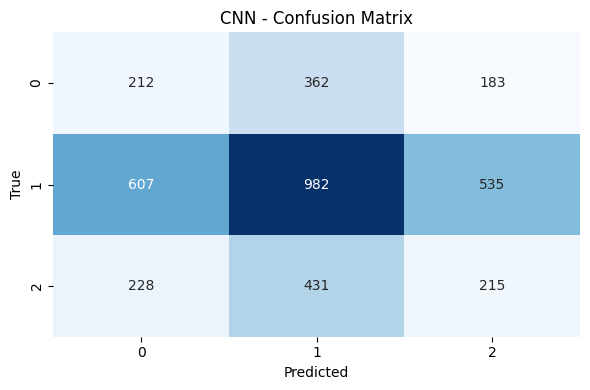

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
📊 LSTM Accuracy: 41.3316%

Classification Report:
              precision    recall  f1-score   support

           0     0.2145    0.3448    0.2644       757
           1     0.5582    0.5800    0.5689      2124
           2     0.1782    0.0675    0.0979       874

    accuracy                         0.4133      3755
   macro avg     0.3170    0.3308    0.3104      3755
weighted avg     0.4005    0.4133    0.3979      3755



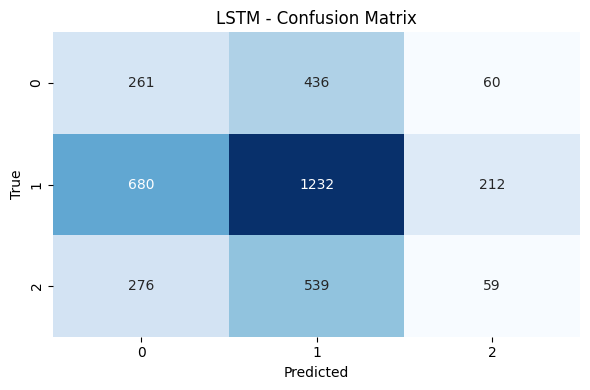

📊 XGBoost Accuracy: 23.1013%

Classification Report:
              precision    recall  f1-score   support

        -1.0     0.0000    0.0000    0.0000       761
         0.0     0.3125    0.0023    0.0046      2140
         1.0     0.2327    0.9886    0.3767       878
         2.0     0.0000    0.0000    0.0000         0

    accuracy                         0.2310      3779
   macro avg     0.1363    0.2477    0.0953      3779
weighted avg     0.2310    0.2310    0.0902      3779



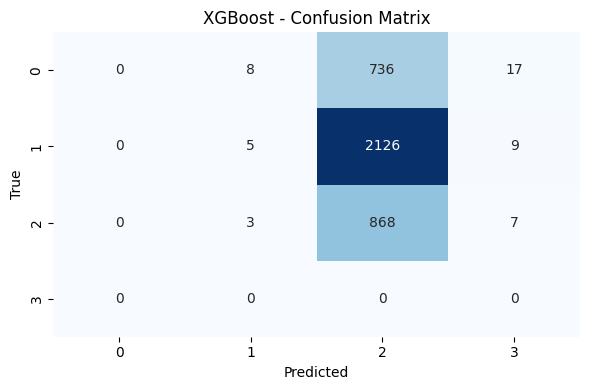

In [43]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation function for any base model
def evaluate_model(model, X_test, y_test, model_name, save_path=None):
    """
    Evaluate a trained model on test data and plot confusion matrix.

    Parameters:
    - model: Trained model object with .predict() method
    - X_test: Feature matrix for testing
    - y_test: True labels (list, NumPy array, or Pandas Series)
    - model_name: String label for model
    - save_path: Optional path to save confusion matrix figure
    """

    # Ensure numpy array format
    y_test = np.array(y_test)

    # Predictions
    y_pred = model.predict(X_test)

    # Handle probability outputs
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)
    elif y_pred.ndim > 1 and y_pred.shape[1] == 1:
        y_pred = (y_pred > 0.5).astype(int).ravel()

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"📊 {model_name} Accuracy: {acc:.4%}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    # Save or show
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Confusion matrix saved to {save_path}")
    else:
        plt.show()

# ==== Evaluate all three base models ====
evaluate_model(cnn_model, X_test_seq, y_test_seq_mapped, "CNN")
evaluate_model(lstm_model, X_test_seq, y_test_seq_mapped, "LSTM")
evaluate_model(xgb_clf, X_test, y_test, "XGBoost")


# O-O-F Predictions

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

# ==== Combine your split data back into one dataset ====
X_tab = np.vstack([X_train, X_val, X_test])
y_tab = np.concatenate([y_train, y_val, y_test])
y_tab = pd.Series(y_tab)  # needed for .map()

# ==== Time series split config ====
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# ==== Label remap (-1, 0, 1) -> (0, 1, 2) ====
label_map = {-1: 0, 0: 1, 1: 2}

# ==== One-hot encoder for DL models ====
enc = OneHotEncoder(sparse_output=False)
y_all_mapped = y_tab.map(label_map)
y_all_oh = enc.fit_transform(y_all_mapped.values.reshape(-1, 1))

# ==== Storage for OOF predictions ====
oof_cnn = np.zeros((len(X_tab), 3))
oof_lstm = np.zeros((len(X_tab), 3))
oof_xgb = np.zeros((len(X_tab), 3))

# ==== Ensure tabular and sequence data match in length ====
min_len = min(len(X_tab), len(X_train_seq), len(y_all_mapped))

X_tab_aligned = X_tab[:min_len]
X_train_seq_aligned = X_train_seq[:min_len]
y_all_mapped_aligned = y_all_mapped.iloc[:min_len]
y_all_oh_aligned = y_all_oh[:min_len]

print(f"Aligned lengths: tab={X_tab_aligned.shape}, seq={X_train_seq_aligned.shape}, y={y_all_mapped_aligned.shape}")


Aligned lengths: tab=(17607, 26), seq=(17607, 24, 26), y=(17607,)


In [22]:
print("=== Generating CNN OOF predictions ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tab_aligned), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")

    # Sequences
    X_seq_tr, X_seq_va = X_train_seq[train_idx], X_train_seq[val_idx]
    y_seq_tr_oh, y_seq_va_oh = y_all_oh[train_idx], y_all_oh[val_idx]

    # Build + compile
    cnn_model = build_cnn_enhanced(input_shape=X_seq_tr.shape[1:], n_classes=3, dropout_rate=0.25)
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train
    cnn_model.fit(X_seq_tr, y_seq_tr_oh, validation_data=(X_seq_va, y_seq_va_oh),
                  epochs=5, batch_size=64, verbose=0)

    # Predict
    oof_cnn[val_idx] = cnn_model.predict(X_seq_va, verbose=0)


=== Generating CNN OOF predictions ===

--- Fold 1/3 ---

--- Fold 2/3 ---

--- Fold 3/3 ---


In [23]:
print("=== Generating LSTM OOF predictions ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tab_aligned), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")

    # Sequences
    X_seq_tr, X_seq_va = X_train_seq[train_idx], X_train_seq[val_idx]
    y_seq_tr_oh, y_seq_va_oh = y_all_oh[train_idx], y_all_oh[val_idx]

    # Build + compile
    lstm_model = build_lstm_enhanced(input_shape=X_seq_tr.shape[1:], n_classes=3, dropout_rate=0.25)
    lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train
    lstm_model.fit(X_seq_tr, y_seq_tr_oh, validation_data=(X_seq_va, y_seq_va_oh),
                   epochs=5, batch_size=64, verbose=0)

    # Predict
    oof_lstm[val_idx] = lstm_model.predict(X_seq_va, verbose=0)


=== Generating LSTM OOF predictions ===

--- Fold 1/3 ---

--- Fold 2/3 ---

--- Fold 3/3 ---


In [24]:
from xgboost import XGBClassifier

print("=== Generating XGB OOF predictions ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tab_aligned), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")

    # Tabular split
    X_tr_tab, X_va_tab = X_tab_aligned[train_idx], X_tab_aligned[val_idx]
    y_tr_tab, y_va_tab = y_all_mapped_aligned.iloc[train_idx], y_all_mapped_aligned.iloc[val_idx]

    # Build with best parameters
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        max_depth=3,
        learning_rate=0.02845916357450999,
        subsample=0.7552507762672391,
        colsample_bytree=0.6666641910069,
        gamma=4.394916003559231,
        min_child_weight=5,
        reg_alpha=0.5856294446650139,
        reg_lambda=1.838450350300456,
        n_estimators=300,
        eval_metric='mlogloss'
    )

    # Train
    xgb_clf.fit(X_tr_tab, y_tr_tab)

    # Predict
    oof_xgb[val_idx] = xgb_clf.predict_proba(X_va_tab)


=== Generating XGB OOF predictions ===

--- Fold 1/3 ---

--- Fold 2/3 ---

--- Fold 3/3 ---


In [25]:
# Stack all model predictions for meta-learner
meta_X_train = np.hstack([oof_cnn, oof_lstm, oof_xgb])
meta_y_train = y_all_mapped.values  # already mapped to (0,1,2)

print("✅ OOF generation complete!")
print("Meta-train shape:", meta_X_train.shape)


✅ OOF generation complete!
Meta-train shape: (25188, 9)


In [26]:

import joblib

# Save OOF predictions and labels
joblib.dump(
    {
        "oof_cnn": oof_cnn,
        "oof_lstm": oof_lstm,
        "oof_xgb": oof_xgb,
        "y": y_all_mapped.values
    },
    "oof_preds.pkl"
)
print("💾 OOF predictions saved to oof_preds.pkl")


💾 OOF predictions saved to oof_preds.pkl


# META LEARNER

In [27]:
# Cell A — Load OOF predictions and align
import joblib
import numpy as np
import pandas as pd
from sklearn.utils import check_array

# Try to load previously saved OOF predictions. If you already have them in memory,
# replace this with the arrays directly (oof_cnn, oof_lstm, oof_xgb, y).
oof_path = "oof_preds.pkl"
obj = joblib.load(oof_path)  # expects dict with "oof_cnn","oof_lstm","oof_xgb","y"

oof_cnn = obj["oof_cnn"]    # shape (n_samples, 3)
oof_lstm = obj["oof_lstm"]
oof_xgb = obj["oof_xgb"]
y_raw   = obj["y"]          # ground-truth labels used during OOF (mapped 0/1/2 or original)

# Make numpy arrays and check sizes
oof_cnn = np.asarray(oof_cnn)
oof_lstm = np.asarray(oof_lstm)
oof_xgb = np.asarray(oof_xgb)
y_raw = np.asarray(y_raw).ravel()

print("Shapes:", oof_cnn.shape, oof_lstm.shape, oof_xgb.shape, y_raw.shape)

# Basic sanity checks
n = len(y_raw)
assert oof_cnn.shape[0] == n and oof_lstm.shape[0] == n and oof_xgb.shape[0] == n, "OOF arrays must align with labels"

# If your y is in -1/0/1 mapping, map to 0/1/2 (consistent)
# Detect automatically if values are -1/0/1 and map to 0/1/2
if set(np.unique(y_raw)).issuperset({-1,0,1}) and set(np.unique(y_raw)).difference({-1,0,1})==set():
    print("Detected labels in {-1,0,1} — remapping to {0,1,2}")
    map_arr = np.array([0 if v==-1 else (1 if v==0 else 2) for v in y_raw])
    y = map_arr
else:
    # assume already 0/1/2
    y = y_raw.copy()

# Confirm class distribution
unique, counts = np.unique(y, return_counts=True)
print("Label distribution (mapped):", dict(zip(unique, counts)))


Shapes: (25188, 3) (25188, 3) (25188, 3) (25188,)
Label distribution (mapped): {np.int64(0): np.int64(5522), np.int64(1): np.int64(13470), np.int64(2): np.int64(6196)}


In [28]:
# Cell B — meta-features construction
import numpy as np
import pandas as pd

# Stack base model probabilities as features
meta_probs = np.hstack([oof_cnn, oof_lstm, oof_xgb])  # shape (n, 9)

# Add engineered meta-features derived from base model outputs:
# - per-sample mean/std/max/min across base model probs
# - disagreements (max prob - 2nd max prob) for confidence
def meta_stats_from_probs(probs_block):
    # probs_block shape (n, n_models * n_classes)
    n_classes = 3
    n_models = probs_block.shape[1] // n_classes
    block = probs_block.reshape(len(probs_block), n_models, n_classes)
    # per model best class prob and best class
    best_probs = block.max(axis=2)                 # (n, n_models)
    best_classes = block.argmax(axis=2)             # (n, n_models)
    # statistics across models on best_probs
    mean_best = best_probs.mean(axis=1)
    std_best = best_probs.std(axis=1)
    max_best = best_probs.max(axis=1)
    min_best = best_probs.min(axis=1)
    # disagreement: how many models agree with majority class
    from scipy.stats import mode
    mode_vals, mode_counts = mode(best_classes, axis=1)
    agree_fraction = (mode_counts.ravel() / n_models)
    # confidence gap: top prob - second top prob per model averaged
    def gap_per_row(row_block):
        # row_block shape (n_models, n_classes)
        gaps = []
        for m in range(row_block.shape[0]):
            arr = np.sort(row_block[m])[::-1]
            gaps.append(arr[0] - (arr[1] if arr.shape[0] > 1 else 0.0))
        return np.mean(gaps)
    gap = np.array([gap_per_row(row) for row in block])

    stats = np.vstack([mean_best, std_best, max_best, min_best, agree_fraction, gap]).T
    stats_cols = ["mean_best_prob", "std_best_prob", "max_best_prob", "min_best_prob", "agree_frac", "avg_top_gap"]
    return stats, stats_cols

stats, stats_cols = meta_stats_from_probs(meta_probs)

# Optionally add a few simple original features if available (e.g. last-hour vol, last return).
# If you saved a features/labels DataFrame earlier, load and align here:
# features_df = pd.read_parquet("features_aligned.parquet")  # or load whatever you have
# extra_feats = features_df.loc[:n-1, ["vol_24h", "ret_1h"]].to_numpy()

# For now, we'll build final meta_X from probs + stats
meta_X = np.hstack([meta_probs, stats])
meta_feature_names = (
    [f"cnn_p{c}" for c in range(3)] +
    [f"lstm_p{c}" for c in range(3)] +
    [f"xgb_p{c}" for c in range(3)] +
    stats_cols
)

print("Meta X shape:", meta_X.shape)
print("Feature names:", meta_feature_names)


Meta X shape: (25188, 15)
Feature names: ['cnn_p0', 'cnn_p1', 'cnn_p2', 'lstm_p0', 'lstm_p1', 'lstm_p2', 'xgb_p0', 'xgb_p1', 'xgb_p2', 'mean_best_prob', 'std_best_prob', 'max_best_prob', 'min_best_prob', 'agree_frac', 'avg_top_gap']


In [35]:
# Cell C — Enhanced Meta-Learner Training with TimeSeriesSplit CV and Calibration
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_sample_weight
import joblib
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # silence early_stopping msg

# ==== Config ====
n_splits = 5
random_state = 42
tscv = TimeSeriesSplit(n_splits=n_splits)

# Hyperparameter candidates — can be extended for full grid/random search
param_grid = [
    {"max_iter": 200, "learning_rate": 0.05, "max_depth": 6},
    {"max_iter": 300, "learning_rate": 0.03, "max_depth": 8},
    {"max_iter": 200, "learning_rate": 0.1,  "max_depth": 4},
]

best_cfg = None
best_score = -1
best_oof_probs = None

print("=== Meta-Learner Training with TimeSeriesSplit ===")
for cfg in param_grid:
    print(f"\nTesting config: {cfg}")
    cfg_val_probs = np.zeros((len(meta_X), 3))
    fold_scores = []

    for fold, (tr_idx, va_idx) in enumerate(tscv.split(meta_X), 1):
        X_tr, X_va = meta_X[tr_idx], meta_X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        # Class balancing
        sample_weight = compute_sample_weight(class_weight="balanced", y=y_tr)

        # Train fold model
        model = HistGradientBoostingClassifier(
            **cfg, early_stopping=True, scoring="f1_macro", random_state=random_state
        )
        model.fit(X_tr, y_tr, sample_weight=sample_weight)

        # Predict
        probs = model.predict_proba(X_va)
        cfg_val_probs[va_idx] = probs

        preds = probs.argmax(axis=1)
        f1 = f1_score(y_va, preds, average="macro", zero_division=0)
        fold_scores.append(f1)
        print(f"  Fold {fold}/{n_splits} — F1_macro: {f1:.4f}")

    mean_f1 = np.mean(fold_scores)
    print(f"  Mean F1_macro: {mean_f1:.4f}")

    # Track best config
    if mean_f1 > best_score:
        best_score = mean_f1
        best_cfg = cfg
        best_oof_probs = cfg_val_probs.copy()

print("\n=== Best Config ===")
print(best_cfg, "with mean F1_macro:", round(best_score, 4))

# ==== Train final model ====
print("\nTraining final meta-learner on full data...")
sample_weight_full = compute_sample_weight(class_weight="balanced", y=y)
final_model = HistGradientBoostingClassifier(**best_cfg, early_stopping=True, random_state=random_state)
final_model.fit(meta_X, y, sample_weight=sample_weight_full)

# ==== Calibrate with time-aware CV ====
# We’ll use TimeSeriesSplit again for calibration instead of random CV
print("Calibrating probabilities (sigmoid)...")
calibrated_models = []
for tr_idx, va_idx in tscv.split(meta_X):
    model_clone = HistGradientBoostingClassifier(**best_cfg, early_stopping=True, random_state=random_state)
    model_clone.fit(meta_X[tr_idx], y[tr_idx], sample_weight=compute_sample_weight(class_weight="balanced", y=y[tr_idx]))
    calibrator = CalibratedClassifierCV(model_clone, method="sigmoid", cv="prefit")
    calibrator.fit(meta_X[va_idx], y[va_idx])
    calibrated_models.append(calibrator)

# Save both raw and calibrated versions
joblib.dump({
    "meta_model": final_model,
    "calibrators": calibrated_models,
    "best_cfg": best_cfg,
    "meta_feature_names": meta_feature_names
}, "meta_model.pkl")

print("✅ Saved meta_model.pkl with best config and calibration.")


=== Meta-Learner Training with TimeSeriesSplit ===

Testing config: {'max_iter': 200, 'learning_rate': 0.05, 'max_depth': 6}
  Fold 1/5 — F1_macro: 0.1415
  Fold 2/5 — F1_macro: 0.7609
  Fold 3/5 — F1_macro: 0.7892
  Fold 4/5 — F1_macro: 0.3063
  Fold 5/5 — F1_macro: 0.2378
  Mean F1_macro: 0.4472

Testing config: {'max_iter': 300, 'learning_rate': 0.03, 'max_depth': 8}
  Fold 1/5 — F1_macro: 0.1415
  Fold 2/5 — F1_macro: 0.7512
  Fold 3/5 — F1_macro: 0.7888
  Fold 4/5 — F1_macro: 0.3074
  Fold 5/5 — F1_macro: 0.2378
  Mean F1_macro: 0.4453

Testing config: {'max_iter': 200, 'learning_rate': 0.1, 'max_depth': 4}
  Fold 1/5 — F1_macro: 0.1415
  Fold 2/5 — F1_macro: 0.7493
  Fold 3/5 — F1_macro: 0.7938
  Fold 4/5 — F1_macro: 0.3083
  Fold 5/5 — F1_macro: 0.2378
  Mean F1_macro: 0.4461

=== Best Config ===
{'max_iter': 200, 'learning_rate': 0.05, 'max_depth': 6} with mean F1_macro: 0.4472

Training final meta-learner on full data...
Calibrating probabilities (sigmoid)...
✅ Saved meta_mode

In [41]:
# Cell D — Load Meta-Learner and Predict
import joblib
import numpy as np

# ==== Load saved meta-model ====
obj = joblib.load("meta_model.pkl")

# ==== Get features (replace with your actual prepared features) ====
# meta_X should already be prepared with the same preprocessing as during training
# y is the true labels (optional if you're only predicting)
# Example:
# meta_X = ...
# y = ...

# ==== Predict probabilities ====
if "calibrators" in obj and obj["calibrators"]:
    # Average predictions from calibrated models
    print("Using calibrated models...")
    calibrators = obj["calibrators"]
    probs_list = [cal.predict_proba(meta_X) for cal in calibrators]
    probs = np.mean(probs_list, axis=0)
else:
    # Fall back to raw meta-model
    print("Using raw meta-model...")
    probs = obj["meta_model"].predict_proba(meta_X)

# ==== Get predicted classes ====
preds = probs.argmax(axis=1)

# ==== If you want metrics ====
from sklearn.metrics import f1_score, accuracy_score
if 'y' in locals():
    print("Accuracy:", accuracy_score(y, preds))
    print("F1_macro:", f1_score(y, preds, average="macro", zero_division=0))


Using calibrated models...
Accuracy: 0.683023662061299
F1_macro: 0.5938662715673404


# save

In [48]:
import joblib

joblib.dump(final_model, "meta_learner.pkl")


['meta_learner.pkl']

In [49]:
from google.colab import files
files.download("meta_learner.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>